# Chapter 3: CLIP Saliency mapping Part 2

| Chapter  | Colab   | Kaggle          | Gradient      | Studio Lab             | Binder             |
|:---------|:--------|:----------------|:--------------|:-----------------------|:-------------------|
| [Chapter 3: CLIP Saliency mapping Part 2](3_model_explainability_and_interpretability/Chapter_3_CLIP_Saliency_mapping_Part2.ipynb)                             | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matthew-mcateer/practicing_trustworthy_machine_learning/blob/main/3_model_explainability_and_interpretability/Chapter_3_CLIP_Saliency_mapping_Part2.ipynb)           | [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/blob/main/3_model_explainability_and_interpretability/Chapter_3_CLIP_Saliency_mapping_Part2.ipynb)           | [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/matthew-mcateer/practicing_trustworthy_machine_learning/blob/main/3_model_explainability_and_interpretability/Chapter_3_CLIP_Saliency_mapping_Part2.ipynb)           | [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/matthew-mcateer/practicing_trustworthy_machine_learning/blob/main/3_model_explainability_and_interpretability/Chapter_3_CLIP_Saliency_mapping_Part2.ipynb)           | [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/matthew-mcateer/practicing_trustworthy_machine_learning/HEAD?urlpath=https%3A%2F%2Fgithub.com%2Fmatthew-mcateer%2Fpracticing_trustworthy_machine_learning%2Fblob%2Fmain%2F3_model_explainability_and_interpretability%2FChapter_3_CLIP_Saliency_mapping_Part2.ipynb)           |

Heavily based on [`hila-chefer/Transformer-MM-Explainability`](https://github.com/hila-chefer/Transformer-MM-Explainability).

For the deep dive explanation into this interpretability method, look to [Chapter 3 of "Practicing Trustworthy Machine Learning"](https://www.oreilly.com/library/view/practicing-trustworthy-machine/9781098120269/).

<!--
Originally found on GitHub at https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/blob/main/3_model_explainability_and_interpretability/Chapter_3_CLIP_Saliency_mapping_Part2.ipynb
-->



In [1]:
#@title Check that your GPU is acessible

#@markdown if this says "Tesla T4" or "Tesla P100" then you'll be able to run this notebook
# 
#@markdown otherwise, try again with menu Runtime --> Factory reset runtime
#@markdown or try at another time of day
#
#@markdown note: other GPUs may be able to run smaller gpt2s -- try replacing "1558M" as model_name with eg "774M"

!nvidia-smi

Sun Nov 27 12:45:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title Installing Dependencies

# Making sure the correct version of PyTorch is installed
!conda install --yes -c pytorch pytorch==1.7.0 torchvision==0.8.1 cudatoolkit=11.0

# Installing other dependencies for OpenAI's CLIP
!pip -qq install ftfy regex tqdm

# Installing dependencies for the saliency mapping
!pip -qq install einops ftfy captum

# Installing CLIP directly from the project Repository
#!pip install git+https://github.com/openai/CLIP.git

!pip -qq install watermark
%load_ext watermark
%watermark -a "Practicing Trustworthy machine Learning" -u -d -v -m -p torch,torchvision,clip,ftfy,regex,tqdm,einops,captum

/bin/bash: conda: command not found
     |████████████████████████████████| 53 kB 247 kB/s 
     |████████████████████████████████| 41 kB 99 kB/s 
     |████████████████████████████████| 1.4 MB 82.9 MB/s 
     |████████████████████████████████| 1.6 MB 31.7 MB/s 
Author: Practicing Trustworthy machine Learning

Last updated: 2022-11-27

Python implementation: CPython
Python version       : 3.7.15
IPython version      : 7.9.0

torch      : 1.12.1+cu113
torchvision: 0.13.1+cu113
clip       : not installed
ftfy       : 6.1.1
regex      : 2022.6.2
tqdm       : 4.64.1
einops     : 0.6.0
captum     : 0.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.10.133+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [3]:
import numpy as np
import torch
from pkg_resources import packaging
%config InlineBackend.figure_format = 'retina'

print("Torch version:", torch.__version__)

Torch version: 1.12.1+cu113


## Saliency mapping on CLIP

In [4]:
import torch
#import clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization

In [5]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  11#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  11#@param {type:"number"}

In [6]:
!mkdir data
!wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -P data/

--2022-11-27 12:45:37--  https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 13.107.246.59, 13.107.213.59, 2620:1ec:bdf::59, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|13.107.246.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1356917 (1.3M) [application/octet-stream]
Saving to: ‘data/bpe_simple_vocab_16e6.txt.gz’

bpe_simple_vocab_16 100%[===================>]   1.29M  --.-KB/s    in 0.02s   

2022-11-27 12:45:37 (74.4 MB/s) - ‘data/bpe_simple_vocab_16e6.txt.gz’ saved [1356917/1356917]



In [7]:
#@title #### Monkey Patching CLIP { display-mode: "form" }

from collections import OrderedDict
from typing import Tuple, Union

import torch
import warnings
from typing import Tuple, Optional

import torch
from torch import Tensor
from torch import nn
from torch.nn.init import xavier_uniform_
from torch.nn.init import constant_
from torch.nn.init import xavier_normal_
from torch.nn.parameter import Parameter
from torch.nn import functional as F

# We define this function as _pad because it takes an argument
# named pad, which clobbers the recursive reference to the pad
# function needed for __torch_function__ support
#pad = F._pad

# This class exists solely for Transformer; it has an annotation stating
# that bias is never None, which appeases TorchScript
class _LinearWithBias(torch.nn.Linear):
    bias: Tensor

    def __init__(self, in_features: int, out_features: int) -> None:
        super().__init__(in_features, out_features, bias=True)

def multi_head_attention_forward(query: Tensor,
                                 key: Tensor,
                                 value: Tensor,
                                 embed_dim_to_check: int,
                                 num_heads: int,
                                 in_proj_weight: Tensor,
                                 in_proj_bias: Tensor,
                                 bias_k: Optional[Tensor],
                                 bias_v: Optional[Tensor],
                                 add_zero_attn: bool,
                                 dropout_p: float,
                                 out_proj_weight: Tensor,
                                 out_proj_bias: Tensor,
                                 training: bool = True,
                                 key_padding_mask: Optional[Tensor] = None,
                                 need_weights: bool = True,
                                 attn_mask: Optional[Tensor] = None,
                                 use_separate_proj_weight: bool = False,
                                 q_proj_weight: Optional[Tensor] = None,
                                 k_proj_weight: Optional[Tensor] = None,
                                 v_proj_weight: Optional[Tensor] = None,
                                 static_k: Optional[Tensor] = None,
                                 static_v: Optional[Tensor] = None,
                                 attention_probs_forward_hook = None,
                                 attention_probs_backwards_hook = None,
                                 ) -> Tuple[Tensor, Optional[Tensor]]:
    if not torch.jit.is_scripting():
        tens_ops = (query, key, value, in_proj_weight, in_proj_bias, bias_k, bias_v,
                    out_proj_weight, out_proj_bias)
        if any([type(t) is not Tensor for t in tens_ops]) and F.has_torch_function(tens_ops):
            return F.handle_torch_function(
                multi_head_attention_forward, tens_ops, query, key, value,
                embed_dim_to_check, num_heads, in_proj_weight, in_proj_bias,
                bias_k, bias_v, add_zero_attn, dropout_p, out_proj_weight,
                out_proj_bias, training=training, key_padding_mask=key_padding_mask,
                need_weights=need_weights, attn_mask=attn_mask,
                use_separate_proj_weight=use_separate_proj_weight,
                q_proj_weight=q_proj_weight, k_proj_weight=k_proj_weight,
                v_proj_weight=v_proj_weight, static_k=static_k, static_v=static_v)
    tgt_len, bsz, embed_dim = query.size()
    assert embed_dim == embed_dim_to_check
    # allow MHA to have different sizes for the feature dimension
    assert key.size(0) == value.size(0) and key.size(1) == value.size(1)

    head_dim = embed_dim // num_heads
    assert head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
    scaling = float(head_dim) ** -0.5

    if not use_separate_proj_weight:
        if torch.equal(query, key) and torch.equal(key, value):
            # self-attention
            q, k, v = F.linear(query, in_proj_weight, in_proj_bias).chunk(3, dim=-1)

        elif torch.equal(key, value):
            # encoder-decoder attention
            # This is inline in_proj function with in_proj_weight and in_proj_bias
            _b = in_proj_bias
            _start = 0
            _end = embed_dim
            _w = in_proj_weight[_start:_end, :]
            if _b is not None:
                _b = _b[_start:_end]
            q = F.linear(query, _w, _b)

            if key is None:
                assert value is None
                k = None
                v = None
            else:

                # This is inline in_proj function with in_proj_weight and in_proj_bias
                _b = in_proj_bias
                _start = embed_dim
                _end = None
                _w = in_proj_weight[_start:, :]
                if _b is not None:
                    _b = _b[_start:]
                k, v = F.linear(key, _w, _b).chunk(2, dim=-1)

        else:
            # This is inline in_proj function with in_proj_weight and in_proj_bias
            _b = in_proj_bias
            _start = 0
            _end = embed_dim
            _w = in_proj_weight[_start:_end, :]
            if _b is not None:
                _b = _b[_start:_end]
            q = F.linear(query, _w, _b)

            # This is inline in_proj function with in_proj_weight and in_proj_bias
            _b = in_proj_bias
            _start = embed_dim
            _end = embed_dim * 2
            _w = in_proj_weight[_start:_end, :]
            if _b is not None:
                _b = _b[_start:_end]
            k = F.linear(key, _w, _b)

            # This is inline in_proj function with in_proj_weight and in_proj_bias
            _b = in_proj_bias
            _start = embed_dim * 2
            _end = None
            _w = in_proj_weight[_start:, :]
            if _b is not None:
                _b = _b[_start:]
            v = F.linear(value, _w, _b)
    else:
        q_proj_weight_non_opt = torch.jit._unwrap_optional(q_proj_weight)
        len1, len2 = q_proj_weight_non_opt.size()
        assert len1 == embed_dim and len2 == query.size(-1)

        k_proj_weight_non_opt = torch.jit._unwrap_optional(k_proj_weight)
        len1, len2 = k_proj_weight_non_opt.size()
        assert len1 == embed_dim and len2 == key.size(-1)

        v_proj_weight_non_opt = torch.jit._unwrap_optional(v_proj_weight)
        len1, len2 = v_proj_weight_non_opt.size()
        assert len1 == embed_dim and len2 == value.size(-1)

        if in_proj_bias is not None:
            q = F.linear(query, q_proj_weight_non_opt, in_proj_bias[0:embed_dim])
            k = F.linear(key, k_proj_weight_non_opt, in_proj_bias[embed_dim:(embed_dim * 2)])
            v = F.linear(value, v_proj_weight_non_opt, in_proj_bias[(embed_dim * 2):])
        else:
            q = F.linear(query, q_proj_weight_non_opt, in_proj_bias)
            k = F.linear(key, k_proj_weight_non_opt, in_proj_bias)
            v = F.linear(value, v_proj_weight_non_opt, in_proj_bias)
    q = q * scaling

    if attn_mask is not None:
        assert attn_mask.dtype == torch.float32 or attn_mask.dtype == torch.float64 or \
            attn_mask.dtype == torch.float16 or attn_mask.dtype == torch.uint8 or attn_mask.dtype == torch.bool, \
            'Only float, byte, and bool types are supported for attn_mask, not {}'.format(attn_mask.dtype)
        if attn_mask.dtype == torch.uint8:
            warnings.warn("Byte tensor for attn_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
            attn_mask = attn_mask.to(torch.bool)

        if attn_mask.dim() == 2:
            attn_mask = attn_mask.unsqueeze(0)
            if list(attn_mask.size()) != [1, query.size(0), key.size(0)]:
                raise RuntimeError('The size of the 2D attn_mask is not correct.')
        elif attn_mask.dim() == 3:
            if list(attn_mask.size()) != [bsz * num_heads, query.size(0), key.size(0)]:
                raise RuntimeError('The size of the 3D attn_mask is not correct.')
        else:
            raise RuntimeError("attn_mask's dimension {} is not supported".format(attn_mask.dim()))
        # attn_mask's dim is 3 now.

    # convert ByteTensor key_padding_mask to bool
    if key_padding_mask is not None and key_padding_mask.dtype == torch.uint8:
        warnings.warn("Byte tensor for key_padding_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
        key_padding_mask = key_padding_mask.to(torch.bool)

    if bias_k is not None and bias_v is not None:
        if static_k is None and static_v is None:
            k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
            v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
            if attn_mask is not None:
                attn_mask = pad(attn_mask, (0, 1))
            if key_padding_mask is not None:
                key_padding_mask = pad(key_padding_mask, (0, 1))
        else:
            assert static_k is None, "bias cannot be added to static key."
            assert static_v is None, "bias cannot be added to static value."
    else:
        assert bias_k is None
        assert bias_v is None

    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    if k is not None:
        k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    if v is not None:
        v = v.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)

    if static_k is not None:
        assert static_k.size(0) == bsz * num_heads
        assert static_k.size(2) == head_dim
        k = static_k

    if static_v is not None:
        assert static_v.size(0) == bsz * num_heads
        assert static_v.size(2) == head_dim
        v = static_v

    src_len = k.size(1)

    if key_padding_mask is not None:
        assert key_padding_mask.size(0) == bsz
        assert key_padding_mask.size(1) == src_len

    if add_zero_attn:
        src_len += 1
        k = torch.cat([k, torch.zeros((k.size(0), 1) + k.size()[2:], dtype=k.dtype, device=k.device)], dim=1)
        v = torch.cat([v, torch.zeros((v.size(0), 1) + v.size()[2:], dtype=v.dtype, device=v.device)], dim=1)
        if attn_mask is not None:
            attn_mask = pad(attn_mask, (0, 1))
        if key_padding_mask is not None:
            key_padding_mask = pad(key_padding_mask, (0, 1))

    attn_output_weights = torch.bmm(q, k.transpose(1, 2))
    assert list(attn_output_weights.size()) == [bsz * num_heads, tgt_len, src_len]

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_output_weights.masked_fill_(attn_mask, float('-inf'))
        else:
            attn_output_weights += attn_mask


    if key_padding_mask is not None:
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        attn_output_weights = attn_output_weights.masked_fill(
            key_padding_mask.unsqueeze(1).unsqueeze(2),
            float('-inf'),
        )
        attn_output_weights = attn_output_weights.view(bsz * num_heads, tgt_len, src_len)

    attn_output_weights = F.softmax(
        attn_output_weights, dim=-1)
    attn_output_weights = F.dropout(attn_output_weights, p=dropout_p, training=training)

    # use hooks for the attention weights if necessary
    if attention_probs_forward_hook is not None and attention_probs_backwards_hook is not None:
        attention_probs_forward_hook(attn_output_weights)
        attn_output_weights.register_hook(attention_probs_backwards_hook)

    attn_output = torch.bmm(attn_output_weights, v)
    assert list(attn_output.size()) == [bsz * num_heads, tgt_len, head_dim]
    attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
    attn_output = F.linear(attn_output, out_proj_weight, out_proj_bias)

    if need_weights:
        # average attention weights over heads
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        return attn_output, attn_output_weights.sum(dim=1) / num_heads
    else:
        return attn_output, None


class MultiheadAttention(torch.nn.Module):
    r"""Allows the model to jointly attend to information
    from different representation subspaces.
    See reference: Attention Is All You Need
    .. math::
        \text{MultiHead}(Q, K, V) = \text{Concat}(head_1,\dots,head_h)W^O
        \text{where} head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
    Args:
        embed_dim: total dimension of the model.
        num_heads: parallel attention heads.
        dropout: a Dropout layer on attn_output_weights. Default: 0.0.
        bias: add bias as module parameter. Default: True.
        add_bias_kv: add bias to the key and value sequences at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        kdim: total number of features in key. Default: None.
        vdim: total number of features in value. Default: None.
        Note: if kdim and vdim are None, they will be set to embed_dim such that
        query, key, and value have the same number of features.
    Examples::
        >>> multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
        >>> attn_output, attn_output_weights = multihead_attn(query, key, value)
    """
    bias_k: Optional[torch.Tensor]
    bias_v: Optional[torch.Tensor]

    def __init__(self, embed_dim, num_heads, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False, kdim=None, vdim=None):
        super(MultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        if self._qkv_same_embed_dim is False:
            self.q_proj_weight = Parameter(torch.Tensor(embed_dim, embed_dim))
            self.k_proj_weight = Parameter(torch.Tensor(embed_dim, self.kdim))
            self.v_proj_weight = Parameter(torch.Tensor(embed_dim, self.vdim))
            self.register_parameter('in_proj_weight', None)
        else:
            self.in_proj_weight = Parameter(torch.empty(3 * embed_dim, embed_dim))
            self.register_parameter('q_proj_weight', None)
            self.register_parameter('k_proj_weight', None)
            self.register_parameter('v_proj_weight', None)

        if bias:
            self.in_proj_bias = Parameter(torch.empty(3 * embed_dim))
        else:
            self.register_parameter('in_proj_bias', None)
        self.out_proj = _LinearWithBias(embed_dim, embed_dim)

        if add_bias_kv:
            self.bias_k = Parameter(torch.empty(1, 1, embed_dim))
            self.bias_v = Parameter(torch.empty(1, 1, embed_dim))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn

        self._reset_parameters()

    def _reset_parameters(self):
        if self._qkv_same_embed_dim:
            xavier_uniform_(self.in_proj_weight)
        else:
            xavier_uniform_(self.q_proj_weight)
            xavier_uniform_(self.k_proj_weight)
            xavier_uniform_(self.v_proj_weight)

        if self.in_proj_bias is not None:
            constant_(self.in_proj_bias, 0.)
            constant_(self.out_proj.bias, 0.)
        if self.bias_k is not None:
            xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            xavier_normal_(self.bias_v)

    def __setstate__(self, state):
        # Support loading old MultiheadAttention checkpoints generated by v1.1.0
        if '_qkv_same_embed_dim' not in state:
            state['_qkv_same_embed_dim'] = True

        super(MultiheadAttention, self).__setstate__(state)

    def forward(self, query, key, value, key_padding_mask=None,
                need_weights=True, attn_mask=None, attention_probs_forward_hook=None, attention_probs_backwards_hook=None):
        r"""
    Args:
        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. When given a binary mask and a value is True,
            the corresponding value on the attention layer will be ignored. When given
            a byte mask and a value is non-zero, the corresponding value on the attention
            layer will be ignored
        need_weights: output attn_output_weights.
        attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
            the batches while a 3D mask allows to specify a different mask for the entries of each batch.
    Shape:
        - Inputs:
        - query: :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
          the embedding dimension.
        - key: :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - value: :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - key_padding_mask: :math:`(N, S)` where N is the batch size, S is the source sequence length.
          If a ByteTensor is provided, the non-zero positions will be ignored while the position
          with the zero positions will be unchanged. If a BoolTensor is provided, the positions with the
          value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
        - attn_mask: 2D mask :math:`(L, S)` where L is the target sequence length, S is the source sequence length.
          3D mask :math:`(N*num_heads, L, S)` where N is the batch size, L is the target sequence length,
          S is the source sequence length. attn_mask ensure that position i is allowed to attend the unmasked
          positions. If a ByteTensor is provided, the non-zero positions are not allowed to attend
          while the zero positions will be unchanged. If a BoolTensor is provided, positions with ``True``
          is not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
          is provided, it will be added to the attention weight.
        - Outputs:
        - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
          E is the embedding dimension.
        - attn_output_weights: :math:`(N, L, S)` where N is the batch size,
          L is the target sequence length, S is the source sequence length.
        """
        if not self._qkv_same_embed_dim:
            return multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask, use_separate_proj_weight=True,
                q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
                v_proj_weight=self.v_proj_weight,
                attention_probs_forward_hook=attention_probs_forward_hook,
                attention_probs_backwards_hook=attention_probs_backwards_hook)
        else:
            return multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask,
                attention_probs_forward_hook=attention_probs_forward_hook,
                attention_probs_backwards_hook=attention_probs_backwards_hook)

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # all conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = multi_head_attention_forward(
            query=x, key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )

        return x[0]


class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim, heads, input_resolution=224, width=64):
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # the 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.avgpool = nn.AvgPool2d(2)
        self.relu = nn.ReLU(inplace=True)

        # residual layers
        self._inplanes = width  # this is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # the ResNet feature dimension
        self.attnpool = AttentionPool2d(input_resolution // 32, embed_dim, heads, output_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            for conv, bn in [(self.conv1, self.bn1), (self.conv2, self.bn2), (self.conv3, self.bn3)]:
                x = self.relu(bn(conv(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.attnpool(x)

        return x


class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

        self.attn_probs = None
        self.attn_grad = None

    def set_attn_probs(self, attn_probs):
        self.attn_probs = attn_probs

    def set_attn_grad(self, attn_grad):
        self.attn_grad = attn_grad

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask, attention_probs_forward_hook=self.set_attn_probs,
                         attention_probs_backwards_hook=self.set_attn_grad)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)


class VisualTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = Transformer(width, layers, heads)

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        return x


class CLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int
                 ):
        super().__init__()

        self.context_length = context_length

        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual = VisualTransformer(
                input_resolution=image_resolution,
                patch_size=vision_patch_size,
                width=vision_width,
                layers=vision_layers,
                heads=vision_heads,
                output_dim=embed_dim
            )

        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask()
        )

        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)

        if isinstance(self.visual, ModifiedResNet):
            if self.visual.attnpool is not None:
                std = self.visual.attnpool.c_proj.in_features ** -0.5
                nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)

            for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)

        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)

    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_text(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

    def forward(self, image, text):
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        # normalized features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logit_scale * text_features @ image_features.t()

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_text


def convert_weights(model: nn.Module):
    """Convert applicable model parameters to fp16"""

    def _convert_weights_to_fp16(l):
        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            l.weight.data = l.weight.data.half()
            if l.bias is not None:
                l.bias.data = l.bias.data.half()

        if isinstance(l, MultiheadAttention):
            for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k", "bias_v"]:
                tensor = getattr(l, attr)
                if tensor is not None:
                    tensor.data = tensor.data.half()

        for name in ["text_projection", "proj"]:
            if hasattr(l, name):
                attr = getattr(l, name)
                if attr is not None:
                    attr.data = attr.data.half()

    model.apply(_convert_weights_to_fp16)


def build_model(state_dict: dict):
    vit = "visual.proj" in state_dict

    if vit:
        vision_width = state_dict["visual.conv1.weight"].shape[0]
        vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
        vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
        grid_size = round((state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
        image_resolution = vision_patch_size * grid_size
    else:
        counts: list = [len(set(k.split(".")[2] for k in state_dict if k.startswith(f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
        vision_layers = tuple(counts)
        vision_width = state_dict["visual.layer1.0.conv1.weight"].shape[0]
        output_width = round((state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5)
        vision_patch_size = None
        assert output_width ** 2 + 1 == state_dict["visual.attnpool.positional_embedding"].shape[0]
        image_resolution = output_width * 32

    embed_dim = state_dict["text_projection"].shape[1]
    context_length = state_dict["positional_embedding"].shape[0]
    vocab_size = state_dict["token_embedding.weight"].shape[0]
    transformer_width = state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(k.split(".")[2] for k in state_dict if k.startswith(f"transformer.resblocks")))

    model = CLIP(
        embed_dim,
        image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers
    )

    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in state_dict:
            del state_dict[key]

    convert_weights(model)
    model.load_state_dict(state_dict)
    return model.eval()

import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


#@lru_cache()
#def default_bpe():
#    return os.path.join(os.path.dirname(os.path.abspath(__file__)), "bpe_simple_vocab_16e6.txt.gz")


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = './data/bpe_simple_vocab_16e6.txt.gz'):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '',)
        pairs = get_pairs(word)

        if not pairs:
            return token+''

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('', ' ')
        return text

_Tokenizer = SimpleTokenizer


import hashlib
import os
import urllib
import warnings
from typing import Union, List

import torch
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from tqdm import tqdm

#__all__ = ["available_models", "load", "tokenize"]
_tokenizer = _Tokenizer()

_MODELS = {
    "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
    "RN101": "https://openaipublic.azureedge.net/clip/models/8fa8567bab74a42d41c5915025a8e4538c3bdbe8804a470a72f30b0d94fab599/RN101.pt",
    "RN50x4": "https://openaipublic.azureedge.net/clip/models/7e526bd135e493cef0776de27d5f42653e6b4c8bf9e0f653bb11773263205fdd/RN50x4.pt",
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
}


def _download(url: str, root: str = os.path.expanduser("~/.cache/clip")):
    os.makedirs(root, exist_ok=True)
    filename = os.path.basename(url)

    expected_sha256 = url.split("/")[-2]
    download_target = os.path.join(root, filename)

    if os.path.exists(download_target) and not os.path.isfile(download_target):
        raise RuntimeError(f"{download_target} exists and is not a regular file")

    if os.path.isfile(download_target):
        if hashlib.sha256(open(download_target, "rb").read()).hexdigest() == expected_sha256:
            return download_target
        else:
            warnings.warn(f"{download_target} exists, but the SHA256 checksum does not match; re-downloading the file")

    with urllib.request.urlopen(url) as source, open(download_target, "wb") as output:
        with tqdm(total=int(source.info().get("Content-Length")), ncols=80, unit='iB', unit_scale=True) as loop:
            while True:
                buffer = source.read(8192)
                if not buffer:
                    break

                output.write(buffer)
                loop.update(len(buffer))

    if hashlib.sha256(open(download_target, "rb").read()).hexdigest() != expected_sha256:
        raise RuntimeError(f"Model has been downloaded but the SHA256 checksum does not not match")

    return download_target


def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=Image.BICUBIC),
        CenterCrop(n_px),
        lambda image: image.convert("RGB"),
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])


def available_models() -> List[str]:
    """Returns the names of available CLIP models"""
    return list(_MODELS.keys())


def load(name: str, device: Union[str, torch.device] = "cuda" if torch.cuda.is_available() else "cpu", jit=True):
    """Load a CLIP model
    Parameters
    ----------
    name : str
        A model name listed by `clip.available_models()`, or the path to a model checkpoint containing the state_dict
    device : Union[str, torch.device]
        The device to put the loaded model
    jit : bool
        Whether to load the optimized JIT model (default) or more hackable non-JIT model.
    Returns
    -------
    model : torch.nn.Module
        The CLIP model
    preprocess : Callable[[PIL.Image], torch.Tensor]
        A torchvision transform that converts a PIL image into a tensor that the returned model can take as its input
    """
    if name in _MODELS:
        model_path = _download(_MODELS[name])
    elif os.path.isfile(name):
        model_path = name
    else:
        raise RuntimeError(f"Model {name} not found; available models = {available_models()}")

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location=device if jit else "cpu").eval()
        state_dict = None
    except RuntimeError:
        # loading saved state dict
        if jit:
            warnings.warn(f"File {model_path} is not a JIT archive. Loading as a state dict instead")
            jit = False
        state_dict = torch.load(model_path, map_location="cpu")

    if not jit:
        model = build_model(state_dict or model.state_dict()).to(device)
        if str(device) == "cpu":
            model.float()
        return model, _transform(model.visual.input_resolution)

    # patch the device names
    device_holder = torch.jit.trace(lambda: torch.ones([]).to(torch.device(device)), example_inputs=[])
    device_node = [n for n in device_holder.graph.findAllNodes("prim::Constant") if "Device" in repr(n)][-1]

    def patch_device(module):
        graphs = [module.graph] if hasattr(module, "graph") else []
        if hasattr(module, "forward1"):
            graphs.append(module.forward1.graph)

        for graph in graphs:
            for node in graph.findAllNodes("prim::Constant"):
                if "value" in node.attributeNames() and str(node["value"]).startswith("cuda"):
                    node.copyAttributes(device_node)

    model.apply(patch_device)
    patch_device(model.encode_image)
    patch_device(model.encode_text)

    # patch dtype to float32 on CPU
    if str(device) == "cpu":
        float_holder = torch.jit.trace(lambda: torch.ones([]).float(), example_inputs=[])
        float_input = list(float_holder.graph.findNode("aten::to").inputs())[1]
        float_node = float_input.node()

        def patch_float(module):
            graphs = [module.graph] if hasattr(module, "graph") else []
            if hasattr(module, "forward1"):
                graphs.append(module.forward1.graph)

            for graph in graphs:
                for node in graph.findAllNodes("aten::to"):
                    inputs = list(node.inputs())
                    for i in [1, 2]:  # dtype can be the second or third argument to aten::to()
                        if inputs[i].node()["value"] == 5:
                            inputs[i].node().copyAttributes(float_node)

        model.apply(patch_float)
        patch_float(model.encode_image)
        patch_float(model.encode_text)

        model.float()

    return model, _transform(model.input_resolution.item())


def tokenize(texts: Union[str, List[str]], context_length: int = 77) -> torch.LongTensor:
    """
    Returns the tokenized representation of given input string(s)
    Parameters
    ----------
    texts : Union[str, List[str]]
        An input string or a list of input strings to tokenize
    context_length : int
        The context length to use; all CLIP models use 77 as the context length
    Returns
    -------
    A two-dimensional tensor containing the resulting tokens, shape = [number of input strings, context_length]
    """
    if isinstance(texts, str):
        texts = [texts]

    sot_token = _tokenizer.encoder["<|startoftext|>"]
    eot_token = _tokenizer.encoder["<|endoftext|>"]
    all_tokens = [[sot_token] + _tokenizer.encode(text) + [eot_token] for text in texts]
    result = torch.zeros(len(all_tokens), context_length, dtype=torch.long)

    for i, tokens in enumerate(all_tokens):
        if len(tokens) > context_length:
            raise RuntimeError(f"Input {texts[i]} is too long for context length {context_length}")
        result[i, :len(tokens)] = torch.tensor(tokens)

    return result

In [8]:
def interpret(image, texts, model, device):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros(
        (logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32
    )
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(
        dict(model.visual.transformer.resblocks.named_children()).values()
    )
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(
        num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype
    ).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
            continue
        grad = torch.autograd.grad(
            one_hot, [blk.attn_probs], retain_graph=True
        )[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]

    text_attn_blocks = list(
        dict(model.transformer.resblocks.named_children()).values()
    )
    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(
        num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype
    ).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
            continue
        grad = torch.autograd.grad(
            one_hot, [blk.attn_probs], retain_graph=True
        )[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text

    return text_relevance, image_relevance

In [9]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image)
    axs[0].axis("off")

    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(
        image_relevance, size=224, mode="bilinear"
    )
    image_relevance = (
        image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    )
    image_relevance = (image_relevance - image_relevance.min()) / (
        image_relevance.max() - image_relevance.min()
    )
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    
    axs[1].imshow(vis)
    axs[1].axis("off")

In [10]:
_Tokenizer = SimpleTokenizer
_tokenizer = _Tokenizer()


def show_heatmap_on_text(text, text_encoding, R_text):
    CLS_idx = text_encoding.argmax(dim=-1)
    R_text = R_text[CLS_idx, 1:CLS_idx]
    text_scores = R_text / R_text.sum()
    text_scores = text_scores.flatten()
    print(text_scores)
    text_tokens = _tokenizer.encode(text)
    text_tokens_decoded = [_tokenizer.decode([a]) for a in text_tokens]
    vis_data_records = [
        visualization.VisualizationDataRecord(
            text_scores, 0, 0, 0, 0, 0, text_tokens_decoded, 1
        )
    ]
    visualization.visualize_text(vis_data_records)

In [11]:
_MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
}
_MODELS

{'ViT-B/32': 'https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt',
 'ViT-B/16': 'https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt'}

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#model, preprocess = ####.load("ViT-B/32", device=device, jit=False)
model, preprocess = load("ViT-B/32", device=device, jit=False)

100%|████████████████████████████████████████| 354M/354M [00:00<00:00, 368MiB/s]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [13]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [14]:
!mkdir clip_images
!wget -q --no-check-certificate --content-disposition \
https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/raw/main/3_model_explainability_and_interpretability/clip_images/astronaut.png  \
https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/raw/main/3_model_explainability_and_interpretability/clip_images/catdog.png  \
https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/raw/main/3_model_explainability_and_interpretability/clip_images/dog.png  \
https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/raw/main/3_model_explainability_and_interpretability/clip_images/dogbird.png \
https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/raw/main/3_model_explainability_and_interpretability/clip_images/dogcat2.png \
https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/raw/main/3_model_explainability_and_interpretability/clip_images/el1.png \
https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/raw/main/3_model_explainability_and_interpretability/clip_images/el2.png \
https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/raw/main/3_model_explainability_and_interpretability/clip_images/el3.png \
https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/raw/main/3_model_explainability_and_interpretability/clip_images/el4.png \
https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/raw/main/3_model_explainability_and_interpretability/clip_images/glasses.png \
https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/raw/main/3_model_explainability_and_interpretability/clip_images/lipstick.png \
https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/raw/main/3_model_explainability_and_interpretability/clip_images/glasses.png \
https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/raw/main/3_model_explainability_and_interpretability/clip_images/noise.png \
https://github.com/matthew-mcateer/practicing_trustworthy_machine_learning/raw/main/3_model_explainability_and_interpretability/clip_images/rocket.png -P clip_images/

Now here is the

tensor([0.0120, 0.1102, 0.1183, 0.1902, 0.1392, 0.3420, 0.0881],
       device='cuda:0', dtype=torch.float16)


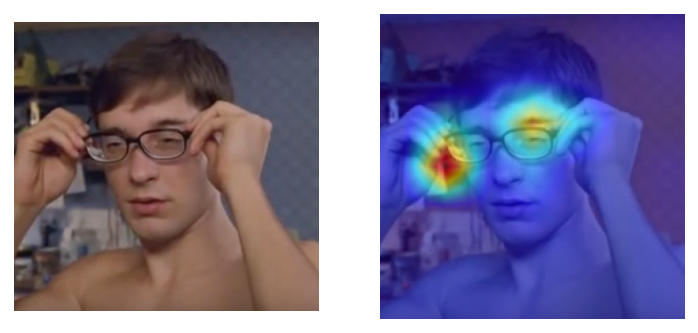

In [15]:
img_path = "clip_images/glasses.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a man with eyeglasses"]

text = tokenize(texts).to(device)

R_text, R_image = interpret(
    model=model, image=img, texts=text, device=device
)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show();

tensor([0.0512, 0.0525, 0.0018, 0.7134, 0.1813], device='cuda:0',
       dtype=torch.float16)


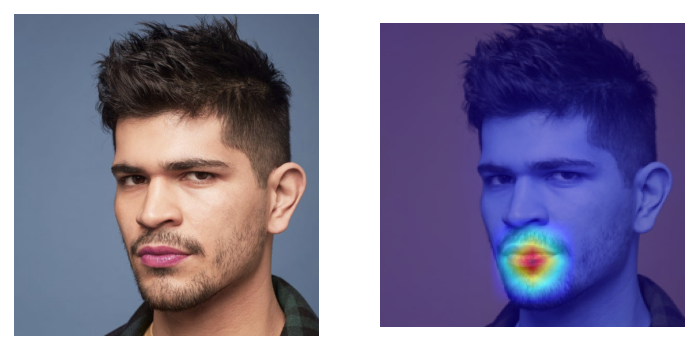

In [16]:
img_path = "clip_images/lipstick.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a man with lipstick"]

text = tokenize(texts).to(device)

R_text, R_image = interpret(
    model=model, image=img, texts=text, device=device
)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show();

tensor([0.0123, 0.1658, 0.3411, 0.0208, 0.0555, 0.2949, 0.1093],
       device='cuda:0', dtype=torch.float16)


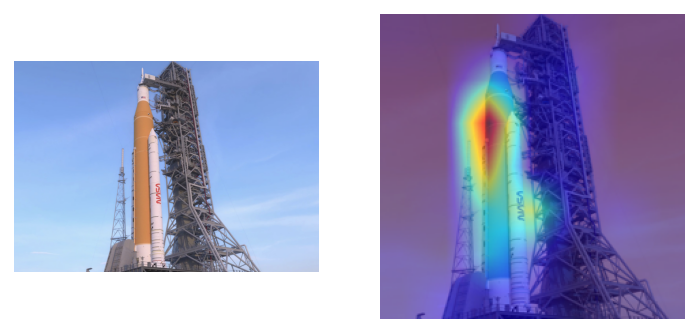

In [17]:
img_path = "clip_images/rocket.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a rocket standing on a launchpad"]

text = tokenize(texts).to(device)

R_text, R_image = interpret(
    model=model, image=img, texts=text, device=device
)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show();

tensor([0.0147, 0.9849], device='cuda:0', dtype=torch.float16)


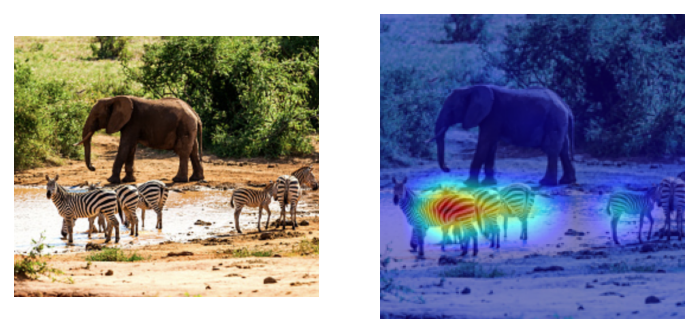

tensor([0.0322, 0.8394, 0.1284], device='cuda:0', dtype=torch.float16)


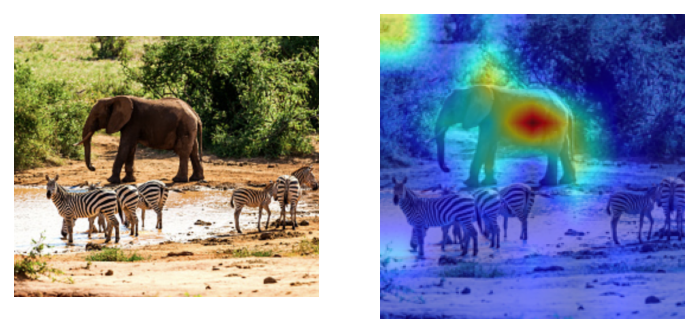

tensor([0.8027, 0.1973], device='cuda:0', dtype=torch.float16)


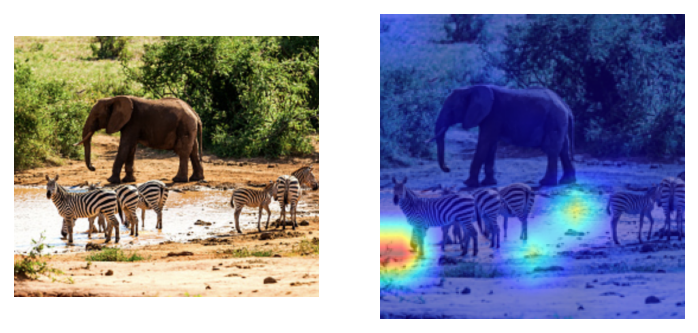

In [18]:
img_path = "clip_images/el2.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a zebra", "an elephant", "a lake"]

text = tokenize(texts).to(device)

R_text, R_image = interpret(
    model=model, image=img, texts=text, device=device
)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show();

tensor([0.0179, 0.9819], device='cuda:0', dtype=torch.float16)


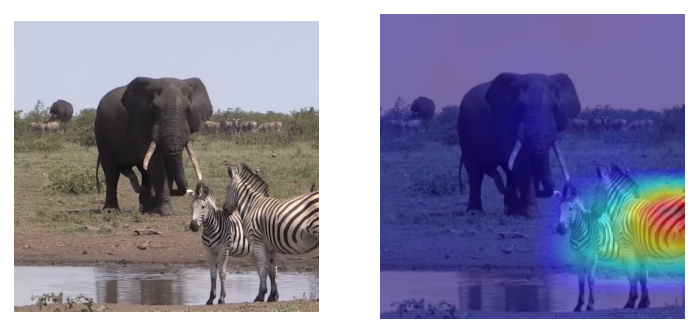

tensor([0.0234, 0.8125, 0.1639], device='cuda:0', dtype=torch.float16)


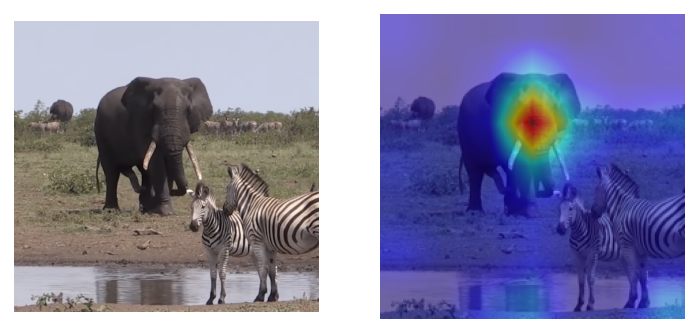

tensor([1.], device='cuda:0', dtype=torch.float16)


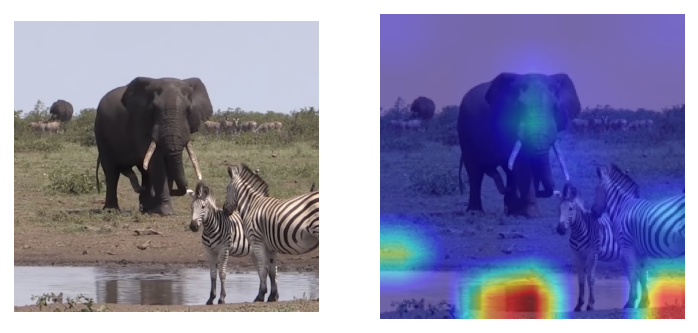

In [19]:
img_path = "clip_images/el3.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a zebra", "an elephant", "water"]

text = tokenize(texts).to(device)

R_text, R_image = interpret(
    model=model, image=img, texts=text, device=device
)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show();

tensor([0.0520, 0.8691, 0.0785], device='cuda:0', dtype=torch.float16)


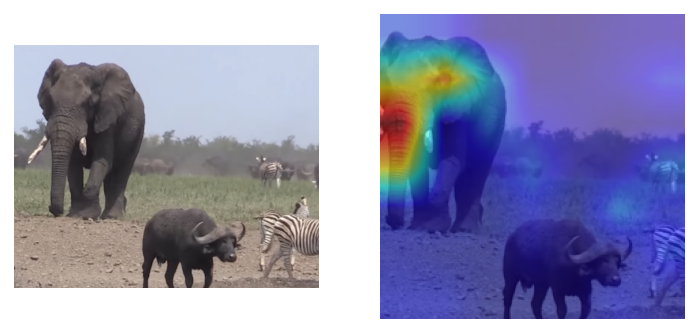

tensor([0.0204, 0.9795], device='cuda:0', dtype=torch.float16)


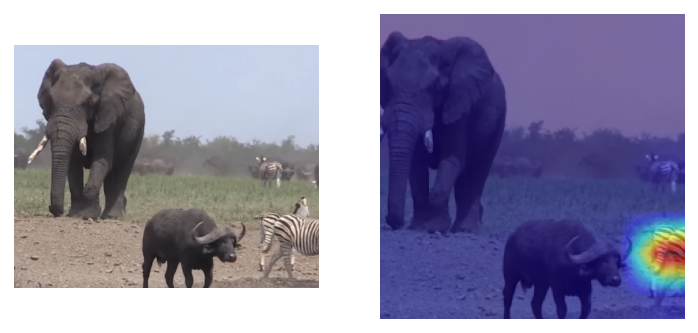

In [20]:
img_path = "clip_images/el4.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["an elephant", "a zebra"]

text = tokenize(texts).to(device)

R_text, R_image = interpret(
    model=model, image=img, texts=text, device=device
)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show();

tensor([0.0844, 0.8140, 0.1014], device='cuda:0', dtype=torch.float16)


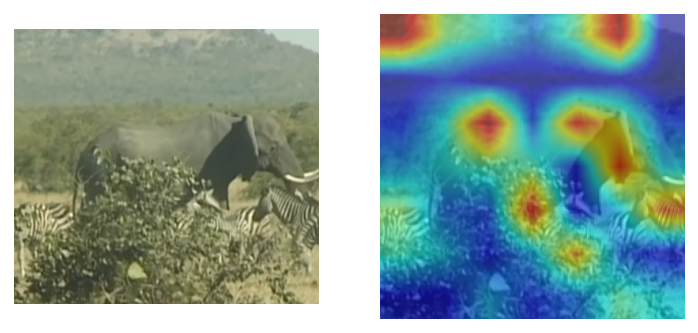

tensor([2.8372e-04, 1.0000e+00], device='cuda:0', dtype=torch.float16)


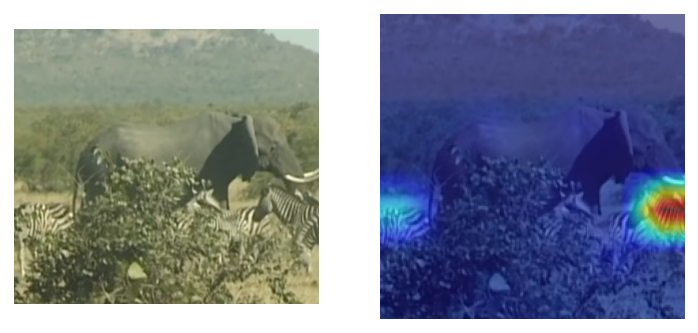

In [21]:
img_path = "clip_images/el1.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["an elephant", "a zebra"]

text = tokenize(texts).to(device)

R_text, R_image = interpret(
    model=model, image=img, texts=text, device=device
)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show();

tensor([0.3142, 0.6860], device='cuda:0', dtype=torch.float16)


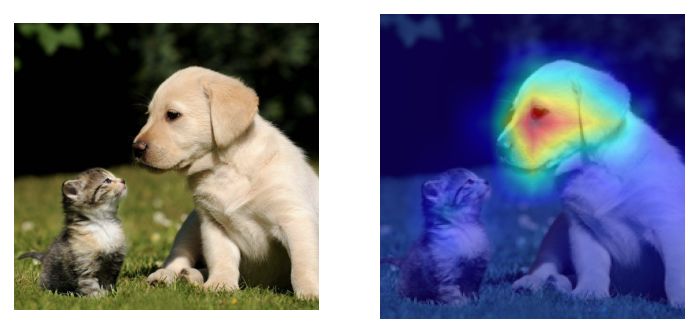

tensor([0.1768, 0.8232], device='cuda:0', dtype=torch.float16)


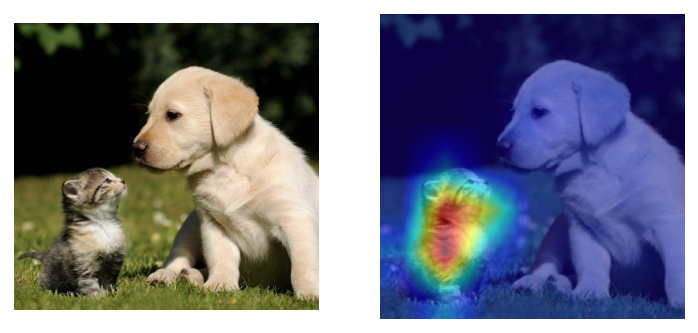

In [22]:
img_path = "clip_images/catdog.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a dog", "a cat"]

text = tokenize(texts).to(device)

R_text, R_image = interpret(
    model=model, image=img, texts=text, device=device
)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show();

tensor([0.0252, 0.3899, 0.0643, 0.5205], device='cuda:0', dtype=torch.float16)


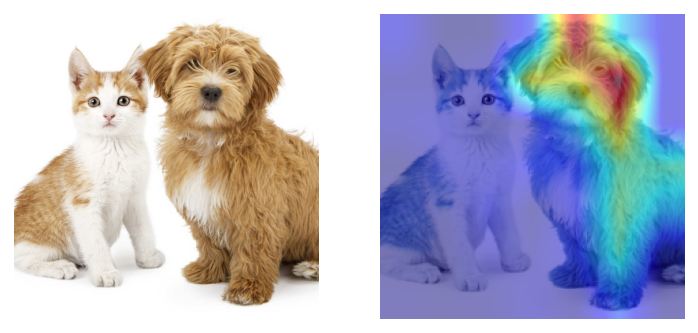

tensor([0.1042, 0.0525, 0.0664, 0.1144, 0.6626], device='cuda:0',
       dtype=torch.float16)


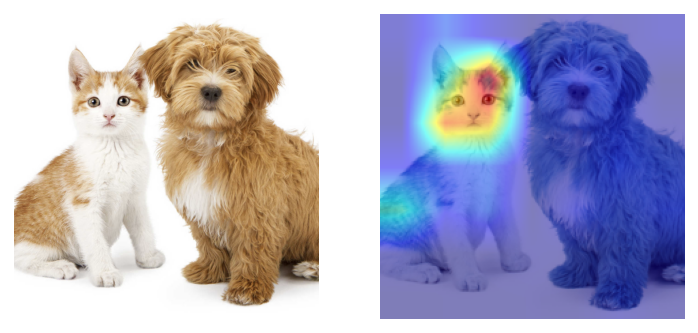

In [23]:
img_path = "clip_images/dogcat2.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a labradoodle", "an Arabian mau cat"]

text = tokenize(texts).to(device)

R_text, R_image = interpret(
    model=model, image=img, texts=text, device=device
)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show();

tensor([0.0499, 0.2223, 0.7275], device='cuda:0', dtype=torch.float16)


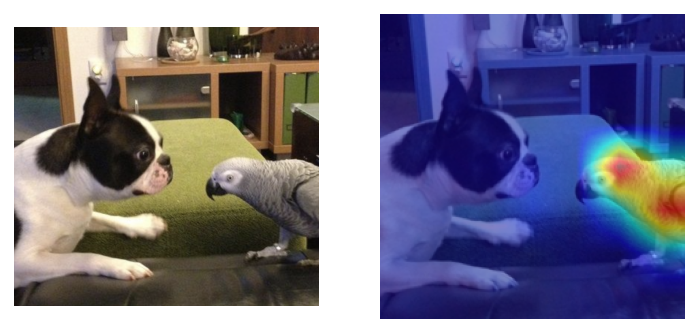

tensor([0.1456, 0.8545], device='cuda:0', dtype=torch.float16)


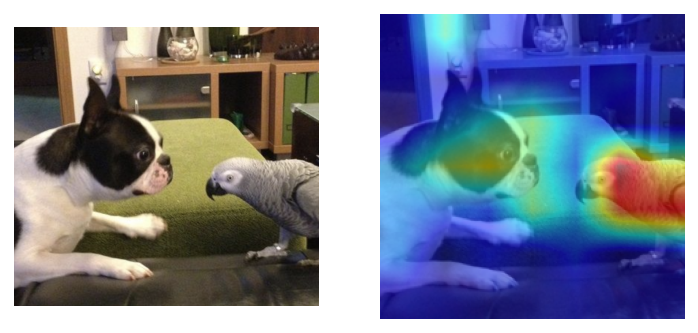

In [24]:
img_path = "clip_images/dogbird.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a parrot", "a dog"]

text = tokenize(texts).to(device)

R_text, R_image = interpret(
    model=model, image=img, texts=text, device=device
)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show();

tensor([0.0118, 0.2208, 0.0000, 0.0410, 0.1410, 0.2986, 0.2866],
       device='cuda:0', dtype=torch.float16)


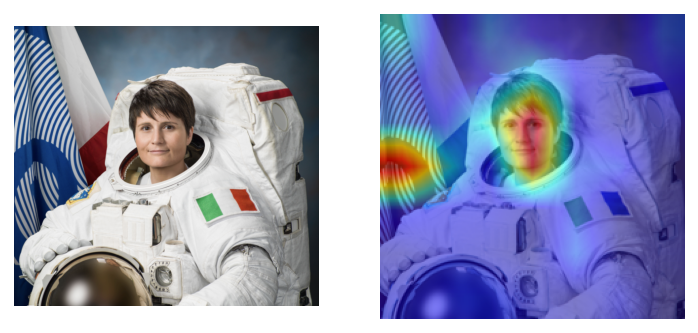

tensor([0.2036, 0.7964], device='cuda:0', dtype=torch.float16)


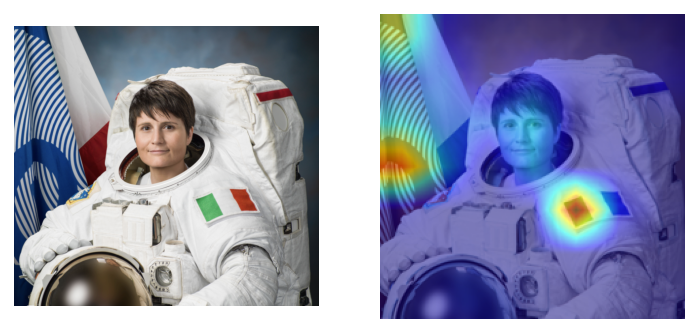

tensor([0.0423, 0.1814, 0.5605, 0.1606, 0.0547], device='cuda:0',
       dtype=torch.float16)


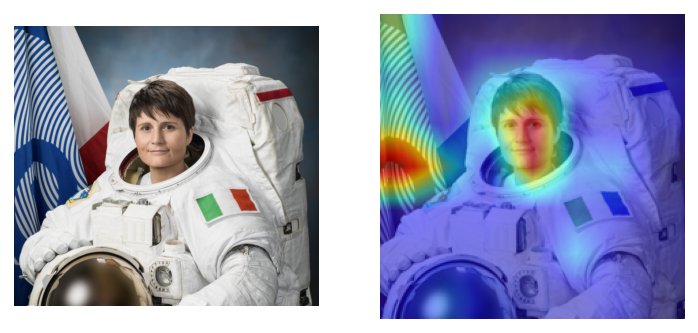

In [25]:
img_path = "clip_images/astronaut.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["a portrait of an astronaut", "a flag", "an astronaut suit"]

text = tokenize(texts).to(device)

R_text, R_image = interpret(
    model=model, image=img, texts=text, device=device
)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show();

CLIP similarity score: 26.046875
tensor([0.0812, 0.0199, 0.0527, 0.0387, 0.8071], device='cuda:0',
       dtype=torch.float16)


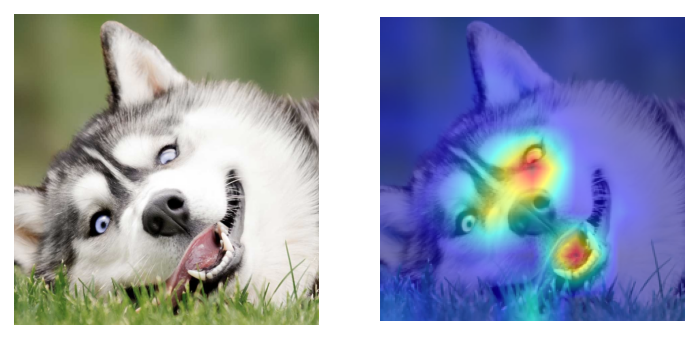

In [26]:
img_path = "clip_images/dog.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["an image of a dog"]

text = tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
print(
    color.BOLD
    + color.BLUE
    + color.UNDERLINE
    + f"CLIP similarity score: {logits_per_image.item()}"
    + color.END
)
R_text, R_image = interpret(
    model=model, image=img, texts=text, device=device
)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show();

CLIP similarity score: 27.75
tensor([0.0369, 0.4478, 0.2842, 0.0593, 0.1721], device='cuda:0',
       dtype=torch.float16)


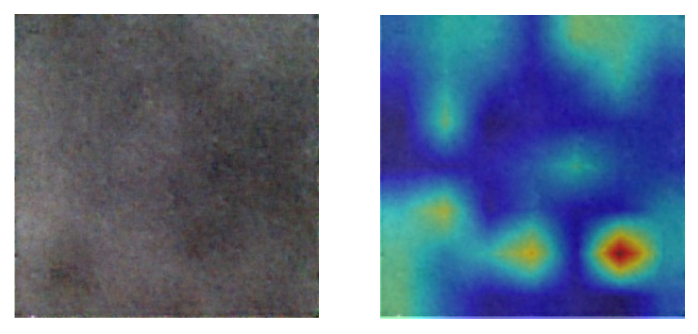

In [27]:
img_path = "clip_images/noise.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["an image of a dog"]

text = tokenize(texts).to(device)
logits_per_image, logits_per_text = model(img, text)
print(
    color.BOLD
    + color.BLUE
    + color.UNDERLINE
    + f"CLIP similarity score: {logits_per_image.item()}"
    + color.END
)
R_text, R_image = interpret(
    model=model, image=img, texts=text, device=device
)
batch_size = text.shape[0]
for i in range(batch_size):
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    plt.show();

## References and Resources

1. [Interacting with CLIP - OpenAI](https://colab.research.google.com/github/openai/clip/blob/master/notebooks/Interacting_with_CLIP.ipynb)
2. [Original CLIP Commit](https://github.com/openai/CLIP/blob/b46f5ac7587d2e1862f8b7b1573179d80dcdd620/clip/model.py)
3. [Modified CLIP model definition](https://github.com/hila-chefer/Transformer-MM-Explainability/blob/main/CLIP/clip/model.py)
4. [Auxillary files](https://github.com/hila-chefer/Transformer-MM-Explainability/blob/main/CLIP/clip/auxilary.py)
